# Data Scientist - Practical Excercise at Clarity AI

# Predicting Poverty using Machine Learning Classification Algorithms

In this project, we'll aim to predict from household surveys if a household is poor or not. We explore how well machine learning algorithms perform when given the task to identify the poor in a given population. The data contains 6562 surveys data from the [Predicting Poverty Competition](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/) published by drivendata.org.

We provide an efficient pipeline for processing the data and predicting poverty in order to help make poverty measurement cheaper and much closer to real-time.

We process the data and select the best features to predict the poverty status of households – a binary class with labels “True” and “False”. Four classification algorithms are used: logistic regression, k-nearest neighbors, random forest and the gradient boosted decision trees implementation XGBoost. Models are compared using the accuracy measure.

### Summary of Results

After analyzing the data, we reached that the best perform algorithm is XGBoost, with an accuracy in the test file of 0.75. We designed a project workflow, including preprocess the data, select the best features and the best classification model to predict poverty and make predictios from the test or holdout file, which is available [here](#workflow). 

For more details, please refer to the the full analysis below.

### Table of Contents
[Data Description](#data-description)  
[Data Exploration](#data-exploration)  
&nbsp;&nbsp;&nbsp;[Exploring Categorical Columns](#explore-categorical)  
&nbsp;&nbsp;&nbsp;[Exploring Numerical Columns](#explore-numeric)\
&nbsp;&nbsp;&nbsp;[Missing Values](#missing-values)\
[Preprocessing the Data](#preprocessing-data)  
[Feature Selection](#feature-selection)\
&nbsp;&nbsp;&nbsp;[Finding Correlated Features](#finding-correlation) 
<br>&nbsp;&nbsp;&nbsp;[Selecting the Best-Performing Features](#select-best-feature)\
[Model Selection and Tuning](#model-selection)  
[Making predictions on holdout data](#prediction-houldout)  
[Project Workflow](#project-workflow)
<br>[Conclusion](#conclusion)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import seaborn as sns
import sklearn
%matplotlib inline

## Data Description <a class="anchor" id="data-description"></a>

We introduce the dataset that will be cleaned and transformed for applying classification algorithms to predict whether or not a given household is poor or not.

First we'll load the household data, including the train and test or  holdout files. Then, we will briefly present the description of the dataset.


In [2]:
def load_dataset(filename):
    df = pd.read_csv(filename, index_col='id')
    return df

# Load the household data
train = load_dataset("Exercise_train.csv")
holdout = load_dataset("Exercise_test.csv")

In [3]:
# summary of the train dataset
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6562 entries, 29252 to 59826
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6562 non-null   int64  
 1   kjkrfgld    6366 non-null   object 
 2   bpowgknt    6357 non-null   object 
 3   raksnhjf    6381 non-null   object 
 4   vwpsxrgk    6364 non-null   object 
 5   omtioxzz    6361 non-null   float64
 6   yfmzwkru    6353 non-null   float64
 7   tiwrsloh    6355 non-null   float64
 8   weioazcf    6366 non-null   float64
 9   poor        6562 non-null   bool   
dtypes: bool(1), float64(4), int64(1), object(4)
memory usage: 519.1+ KB


,Unnamed: 0,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
id,,,,,,,,,,
29252,2225,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
98286,1598,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
49040,7896,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
35261,1458,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
98833,1817,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


This information shows how the dataset contains 10 columns, where most of them are strings and floats. Some columns have missing values, but none have more than ~3% null values.

Since the column names have been encoded as random string, we will rename them for a better understanding as categ_col_number and num_col_number to call the categorical and numeric columns, respectivelly.

In [4]:
# Fix the colum's name dataframe for a better identification of the columns
def fix_colum_name(df):
    df = df.rename({'kjkrfgld': 'categ_col_1', 'bpowgknt': 'categ_col_2', 'raksnhjf': 'categ_col_3', 'vwpsxrgk': 'categ_col_4',
                   'omtioxzz': 'num_col_1', 'yfmzwkru': 'num_col_2', 'tiwrsloh': 'num_col_3', 'weioazcf': 'num_col_4'}, axis=1)  # new method
    return df

train = fix_colum_name(train)
train.head(3)

,Unnamed: 0,categ_col_1,categ_col_2,categ_col_3,categ_col_4,num_col_1,num_col_2,num_col_3,num_col_4,poor
id,,,,,,,,,,
29252,2225,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
98286,1598,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
49040,7896,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True


## Data Exploration <a class="anchor" id="data-exploration"></a>

In this section, we investigate the characteristics of the data. We analyze the statistical information of the dataset and missing values in the data.

In [5]:
train.describe(include = 'all')

,Unnamed: 0,categ_col_1,categ_col_2,categ_col_3,categ_col_4,num_col_1,num_col_2,num_col_3,num_col_4,poor
count,6562.000000,6366,6357,6381,6364,6361.000000,6353.000000,6355.000000,6366.000000,6562
unique,NaN,8,6,5,31,NaN,NaN,NaN,NaN,2
top,NaN,qzGkS,THHLT,DtMvg,sPNOc,NaN,NaN,NaN,NaN,False
freq,NaN,2072,3095,3095,314,NaN,NaN,NaN,NaN,3609
mean,4113.757543,NaN,NaN,NaN,NaN,17.455117,-2.826696,-4.194335,-7.461828,NaN
std,2353.382080,NaN,NaN,NaN,NaN,10.924393,12.615775,4.476410,11.198626,NaN
min,0.000000,NaN,NaN,NaN,NaN,-127.000000,-4.000000,-31.000000,-74.500000,NaN
25%,2088.500000,NaN,NaN,NaN,NaN,12.000000,-4.000000,-7.000000,-14.500000,NaN
50%,4115.500000,NaN,NaN,NaN,NaN,12.000000,-3.000000,-3.000000,-4.500000,NaN
75%,6156.750000,NaN,NaN,NaN,NaN,21.000000,-2.000000,-1.000000,0.500000,NaN


These results show how most of the categorical features present less than 10 unique values, except *categ_col_4* that presents 31 different values. We will exploring the distribution of these columns in the next subsection.

The four numeric columns need more investigation to analyze the values's distribution. We will plot the values of these columns with a boxplot to identify any values that look wrong.

The class attribute poor presents two values, where the most frequent is False. Notice that, both values are balanced in the dataset, which is an important feature since the dataset is balanced and can be used classical classification algorithms.

A small number of missing values for each column are presented. However, we will present a further analyzes of how to handel them.

Finally, the *Unnamed: 0* feature seems to be another ID, presenting a different value for each row. Then, it will be dropped.

### Exploring Categorical Columns  <a class="anchor" id="explore-categorical"></a>

Now, we will generate plot bars for each categorical column, calling the value_counts method to get a count of unique values for them.

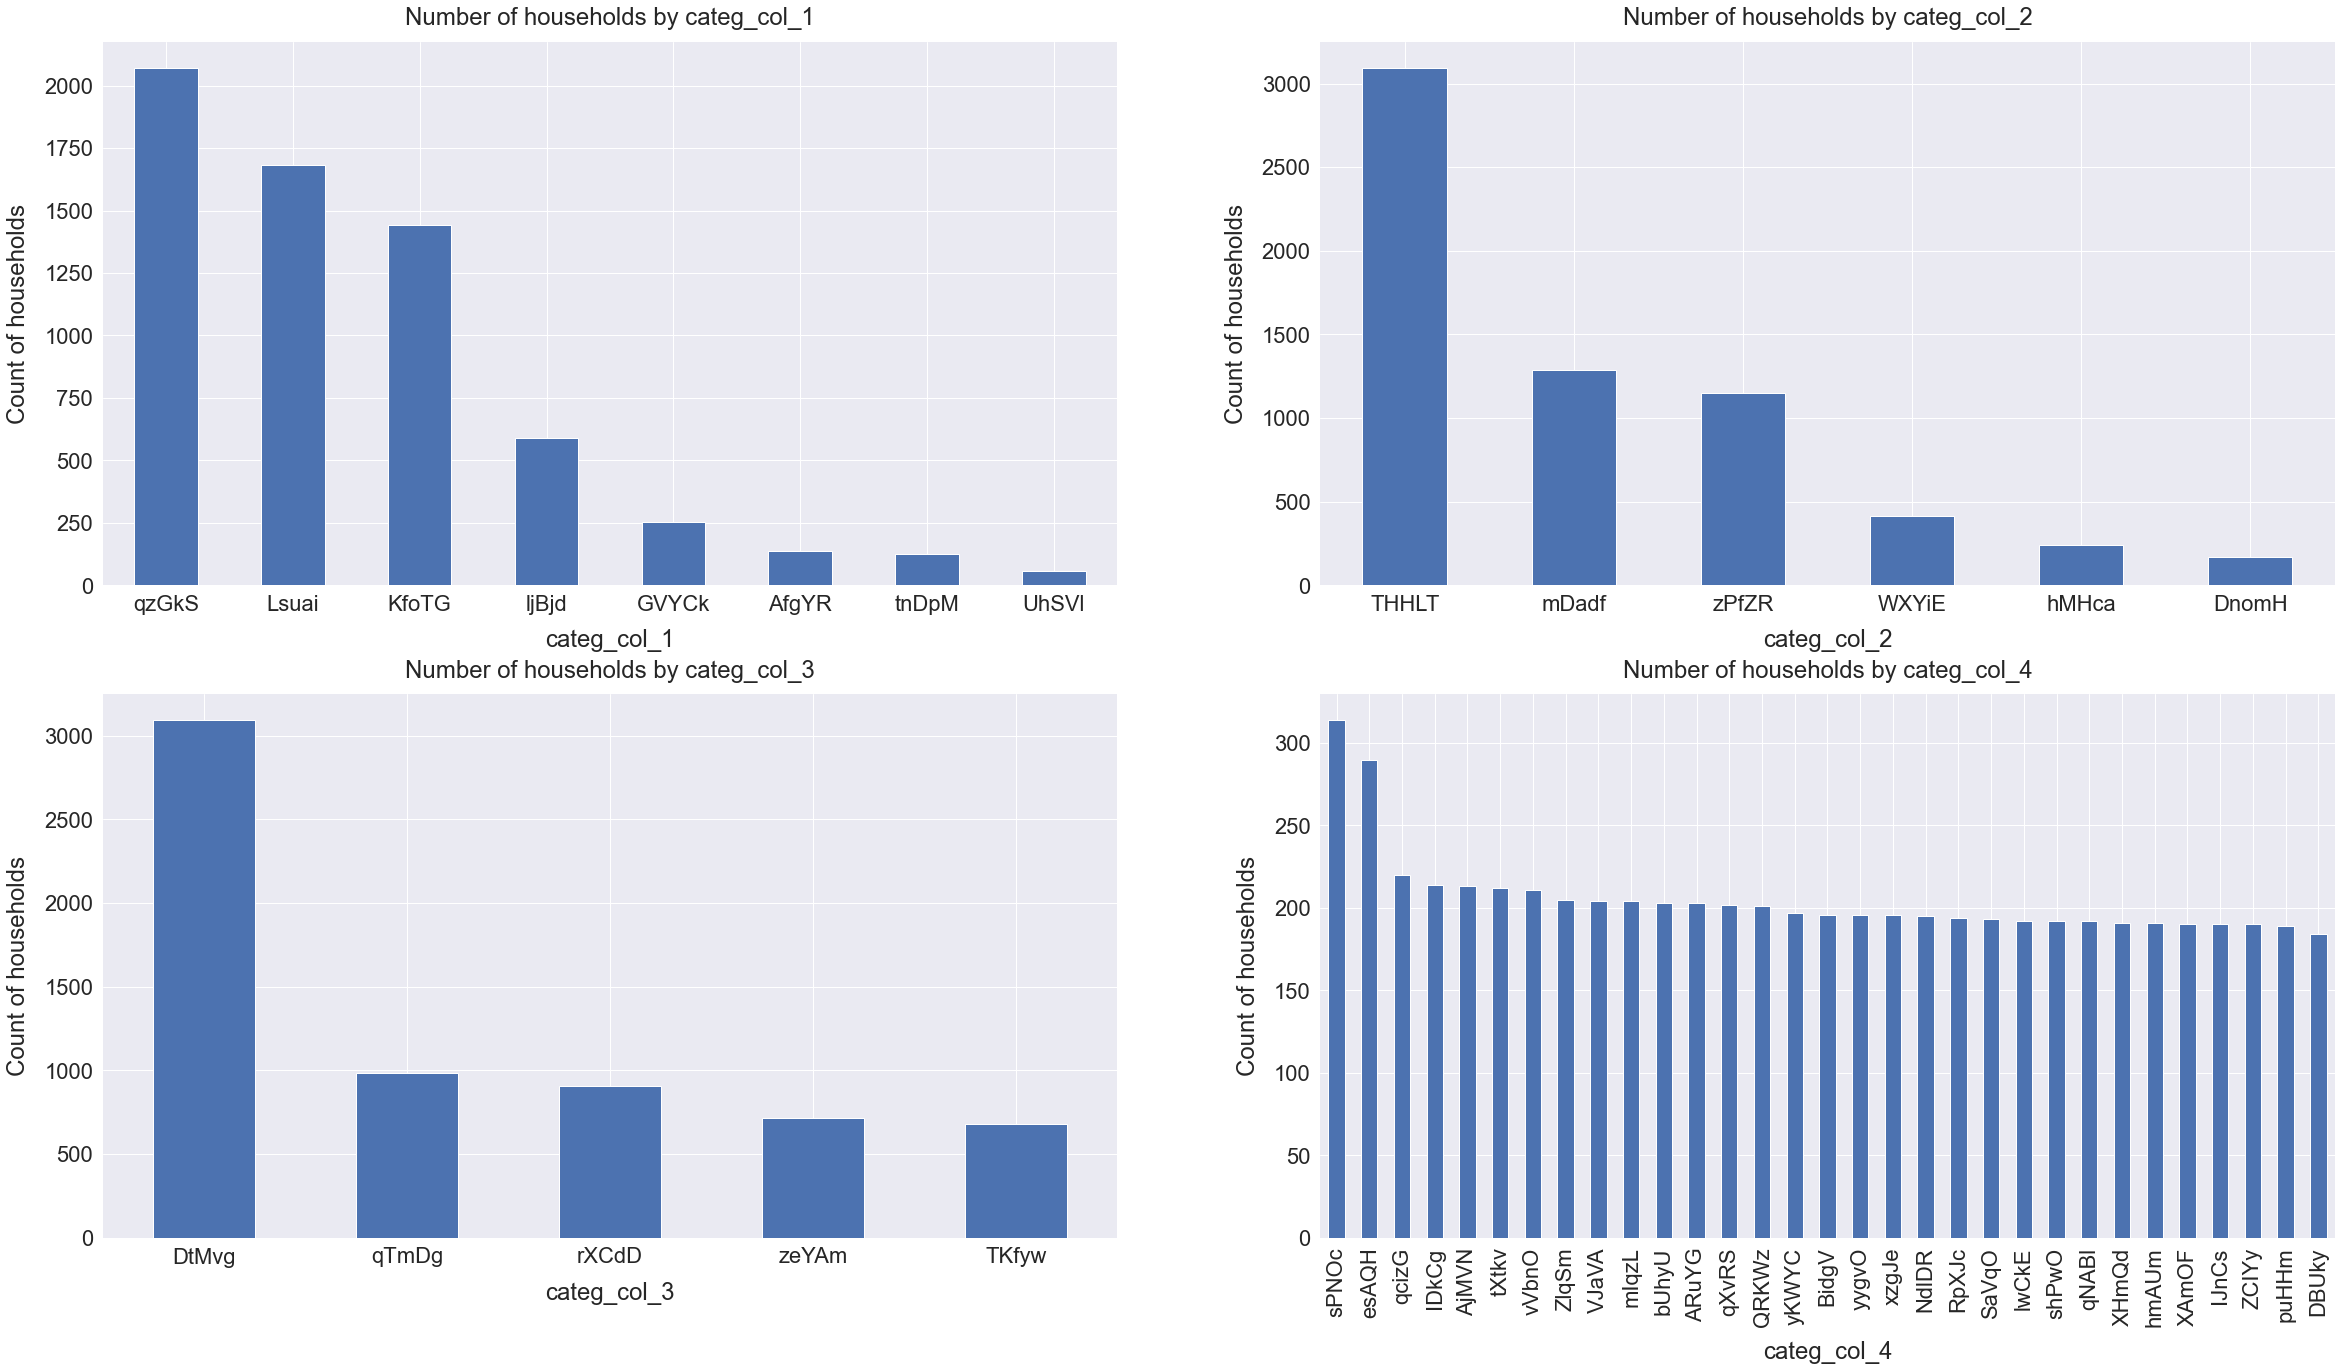

In [6]:
# plotting the number of each different value from the categorical columns using bar charts
sns.set(font_scale=2)
fig = plt.figure(figsize=(40, 22))
for i in range(0,4):
    col_name = "categ_col_{col_num}".format(col_num = i+1)
    ax = fig.add_subplot(2,2,i+1)
    if i != 3:
        ax = train[col_name].value_counts().plot(kind='bar', rot=0)
    else:
        ax = train[col_name].value_counts().plot(kind='bar')
    for key,spine in ax.spines.items():
         spine.set_visible(False)
    ax.set_xlabel(col_name, labelpad=14)
    ax.set_ylabel("Count of households", labelpad=14)
    ax.set_title("Number of households by " + col_name, y=1.02);    

These figures show how the *categ_col_1* and *categ_col_2*, *categ_col_3* columns present a value with a high number of households in comparison with the other unique values. On the other hand, the *categ_col_4* has a higher number of unique values than the other columns, presenting two high frequency values and a similar distribution for the rest of possible values in the dataset. Then, we will consider the four features in the following analysis.

### Exploring Numeric Columns <a class="anchor" id="explore-numeric"></a>

In this section, we show the values' distribution from numeric columns using boxplots.

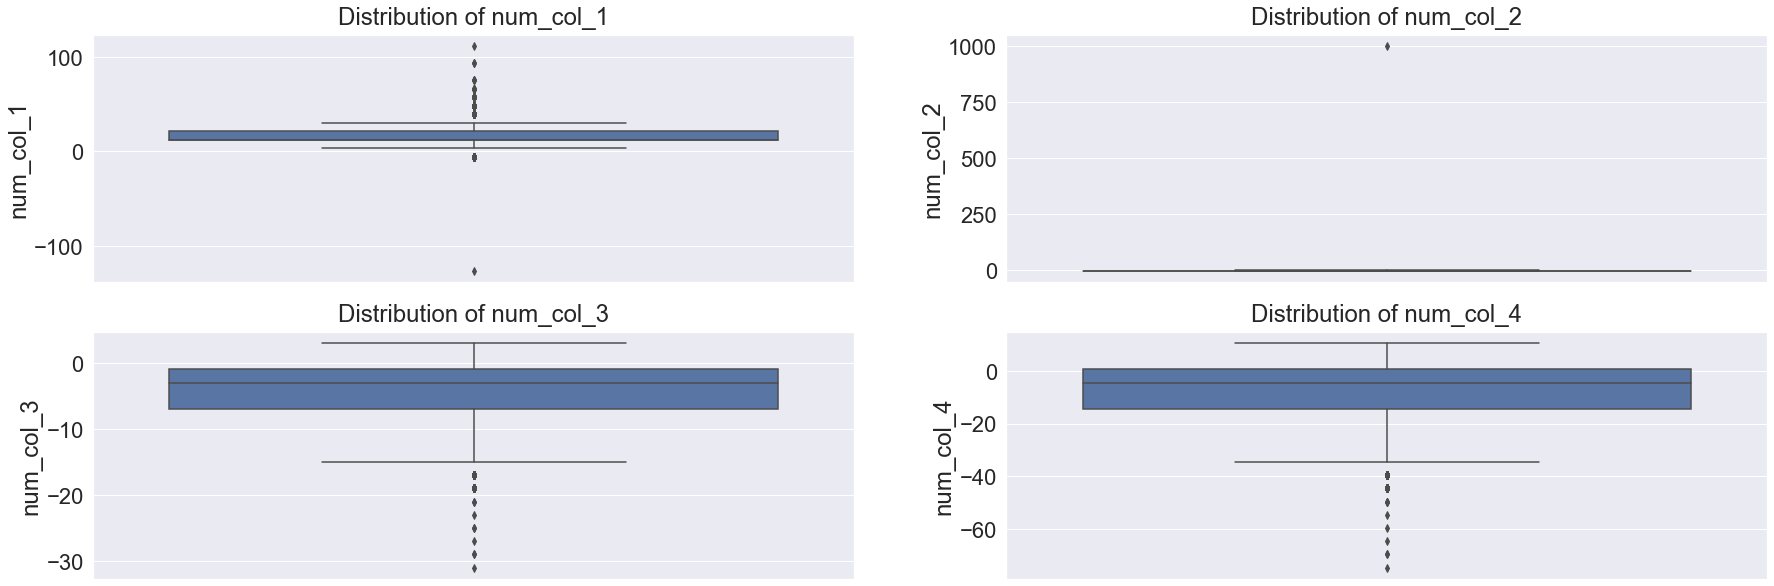

In [7]:
# plotting the distribution of the numeric columns using boxplot charts
fig = plt.figure(figsize=(30,10))
for i in range(0,4):
    col_name = "num_col_{col_num}".format(col_num = i+1)
    ax = fig.add_subplot(2,2,i+1)
    ax = sns.boxplot(y=train[col_name])
    ax.set_title("Distribution of " + col_name, y=1.02);

By the analysis of the figures presented, we can highlight the following facts:

- Most of the households have *num_col_1*'s values beteween 12 and 25, presenting low variability of the data. However, many outliers values are presented, incluiding values higher than the upper whisker and lower than the lower one.

- The values of *num_col_2* are centered, close to the median. Notice that an outlier is presented, that will be removed.

- The *num_col_3* and *num_col_4* columns present a similar values's distribution. The values are skewed, where the majority of the data are located on the low side of the graph. Both columns present outliers values that are below the  lower whisker.

Let's analyze how to deal with the outliers. First, we will count how many outliers present each columns, using the IQR score, where anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier.

In [8]:
numeric_cols = ['num_col_1','num_col_2','num_col_3', 'num_col_4']
data_col = train[numeric_cols]
Q1 = data_col.quantile(0.25)
Q3 = data_col.quantile(0.75)
IQR = Q3 - Q1

# get a dataframe where True represent that the value is an outlier.
outlier_df = ((data_col < (Q1 - 1.5 * IQR)) |(data_col > (Q3 + 1.5 * IQR)))

print("Number of outlier for each numeric colum that are represented in the True row")
outlier_df.apply(pd.Series.value_counts)

Number of outlier for each numeric colum that are represented in the True row


,num_col_1,num_col_2,num_col_3,num_col_4
False,6145,6561,6489,6489
True,417,1,73,73


The above table shows that num_col_1 present the highest number of outliers. 

Let's analyze how many rows would be removed if we remove the rows with an outlier in any of the columns.

In [9]:
print("The number of rows that would be removed if present outliers values is: {}".format((outlier_df.sum(axis=1) > 0).sum()))

The number of rows that would be removed if present outliers values is: 475


Since the num_col_1 presents many outliers, we will repeat the above analysis without considering it.

In [10]:
print("The number of rows that would be removed if present outliers in columns 'num_col_2', 'num_col_3' and 'num_col_4' is : {}".format((outlier_df[['num_col_2','num_col_3', 'num_col_4']].sum(axis=1) > 0).sum()))

The number of rows that would be removed if present outliers in columns 'num_col_2', 'num_col_3' and 'num_col_4' is : 75


Few rows would be removed if we consider the oultliers in the 'num_col_2', 'num_col_3' and 'num_col_4' columns. For this reason, we will remove them and the outlier values from 'num_col_1' will be repleaced by the median value.

### Missing Values <a class="anchor" id="missing-values"></a>

In this section, we will check for missing values in the dataset and analyse how to handel them.

In [11]:
# Obtain the number and percentage of missing values for each column
print(" Missing value for each column")
missing_value_cnt = train.isnull().sum() 
percentage_missing_df = train.isnull().sum() * 100 / len(train)
missing_values_table = pd.concat([missing_value_cnt, percentage_missing_df], axis=1)
missing_values_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage'})

 Missing value for each column


,Missing Values,Percentage
Unnamed: 0,0,0.000000
categ_col_1,196,2.986894
categ_col_2,205,3.124048
categ_col_3,181,2.758305
categ_col_4,198,3.017373
num_col_1,201,3.063091
num_col_2,209,3.185005
num_col_3,207,3.154526
num_col_4,196,2.986894
poor,0,0.000000


We can see above that our dataframe has missing values around 200 that representing ~3% of the dataset in all columns.

We can learn more about where these missing values are located by visualizing them with a heatmap, a graphical representation of our data in which values are represented as colors. We'll use the seaborn library to create the heatmap. Notice that, missing values are highlighted in light gray and all other values in black.

<AxesSubplot:ylabel='id'>

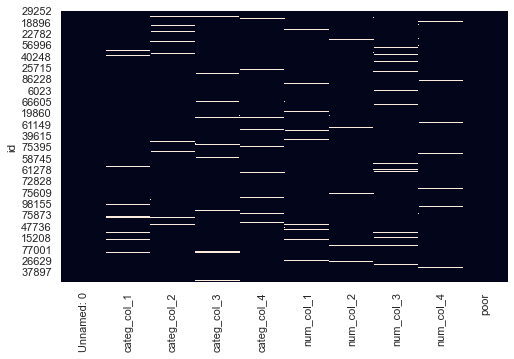

In [12]:
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(8,5))
sns.heatmap(train.isnull(), cbar=False)

We can make the following observations:

 - No values are missing in the Unnamed:0 and poor columns.
 - There are some rows with missing values in more than one columns, but it seems that most of them present missing values in few columns.
   
Let's analyze how many rows would be removed if we remove the rows with a missing value in any column.


In [13]:
print("Number of initial rows in the dataset: {}".format(train.shape[0]))

print("Number of rows with missing values that would be removed : {}".format((train.shape[0] - train.dropna().shape[0])))

Number of initial rows in the dataset: 6562
Number of rows with missing values that would be removed : 1430


Notice that, if we delete all rows that present any missing value, we would delete 1430 rows, that represent the 21% of the dataset. 

It seems that some rows only present missing values in the numeric columns. For this reason, let's analyse how many rows would be deleted if we replece the missing values in numerical columns and remove the rows with missing values in the rest of variables.

In [14]:
df_clean = train.fillna(train.mean())
print("Number of rows with missing values that would be removed after fill the numeric columns: {}".format((df_clean.shape[0] - df_clean.dropna().shape[0])))

Number of rows with missing values that would be removed after fill the numeric columns: 747


In this case, would be deleted 747 rows, that represent a quite small number to remove. 

Finally, we will correct missing values in the following way:
- Repleace missing value with the mean for each numeric column.
- Remove the rows with missing values from the categorical columns

## Preprocessing the Data <a class="anchor" id="preprocessing-data"></a>

In this section, we preprocess the data take into account the consideration mentioned above. We will do the following process:

- Fix the column names, using the function defined above.
- Remove the "Unnamed: 0", since present a different value for each row.
- Treat the outliers (*outlier_treatment function*), removing the outliers from 'num_col_2', 'num_col_3' and 'num_col_4' columns and the ones from 'num_col_1' will be repleaced by the median value. 
- Process missing values (*process_missing function*), where the ones from numeric columns will be repleaced with the mean value and the rest ones will be removed.
- Rescale the data using *minmax_scale* from *sklearn.preprocessing*, since we can see a big difference between the range of each numeric colum. In order to make sure these values are equally weighted within the classification model, we'll need to rescale the data.
- Create dummy columns for each unique value for the categorical columns since most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.
  


In [15]:
# function to treat outliers 
def outlier_treatment(df):
     # outlier treatment
    # removing all rows that are outliers from the 'num_col_2', 'num_col_3' and 'num_col_4' features using IQR
    Q1 = df[['num_col_2','num_col_3', 'num_col_4']].quantile(0.25)
    Q3 = df[['num_col_2','num_col_3', 'num_col_4']].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[['num_col_2','num_col_3', 'num_col_4']] < (Q1 - 1.5 * IQR)) |(df[['num_col_2','num_col_3', 'num_col_4']] > (Q3 + 1.5 * IQR))).any(axis=1)]
   
    # replace all those values that are outliers with the median value in the 'num_col_1' variable.
    quantile_50 = df['num_col_1'].quantile(0.50)
    Q1_num_col_1 = df['num_col_1'].quantile(0.25)
    Q3_num_col_1 = df['num_col_1'].quantile(0.75)
    IQR_num_col_1 = Q3_num_col_1 - Q1_num_col_1
    outlier = ((df['num_col_1'] < (Q1_num_col_1 - 1.5 * IQR_num_col_1)) |(df['num_col_1'] > (Q3_num_col_1 + 1.5 * IQR_num_col_1)))
    df = df.copy()
    df.loc[outlier, 'num_col_1'] = quantile_50
    return df

# function to handel missing values
def process_missing(df):
   
    # replace all missing values in numeric columns with the mean
    df = df.fillna(df.mean())
    # remove rows with any missing values in categorical features
    df = df.dropna()
    
    return df

In [16]:
# function to preprocess the data, doing all the actions needed.
def pre_process(df):
    df = fix_colum_name(df)
    df = df.drop(["Unnamed: 0"],axis=1) #delete "Unnamed: 0" column
    df = outlier_treatment(df)
    df = process_missing(df)
    
    # rescale data using minmax_scale from sklearn.preprocessing
    for col in ['num_col_1','num_col_2','num_col_3','num_col_4']:
        df[col] = minmax_scale(df[col])

    ## Create dummy columns and add back to the dataframe!
    df = pd.get_dummies(df, drop_first=True, prefix_sep='__')
    
    return df

# preprocess train and holdout dataset using pre_process function
train = load_dataset("Exercise_train.csv")
holdout = load_dataset("Exercise_test.csv")
train = pre_process(train)
holdout = pre_process(holdout)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5746 entries, 98286 to 59826
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_col_1           5746 non-null   float64
 1   num_col_2           5746 non-null   float64
 2   num_col_3           5746 non-null   float64
 3   num_col_4           5746 non-null   float64
 4   poor                5746 non-null   bool   
 5   categ_col_1__GVYCk  5746 non-null   uint8  
 6   categ_col_1__KfoTG  5746 non-null   uint8  
 7   categ_col_1__Lsuai  5746 non-null   uint8  
 8   categ_col_1__UhSVl  5746 non-null   uint8  
 9   categ_col_1__ljBjd  5746 non-null   uint8  
 10  categ_col_1__qzGkS  5746 non-null   uint8  
 11  categ_col_1__tnDpM  5746 non-null   uint8  
 12  categ_col_2__THHLT  5746 non-null   uint8  
 13  categ_col_2__WXYiE  5746 non-null   uint8  
 14  categ_col_2__hMHca  5746 non-null   uint8  
 15  categ_col_2__mDadf  5746 non-null   uint8  
 16  c

The train dataset after the preprocessing process has 5746 rows and 50 features to train and the target column *poor*.

## Feature Selection <a class="anchor" id="feature-selection"></a>

In order to select the best-performing features, we analyze the correlation beteween features and then, we will use the logit coefficients to select the most relevant features, using the *feature_selection.RFECV class*.

###  Finding Correlated Features <a class="anchor" id="finding-correlation"></a> 
We now have 50 possible feature columns we can use to train our model. Since, we are adding more features, the collinearity between them need to be checked.  Collinearity occurs where more than one feature contains data that are similar. 
A  common way to spot collinearity is to plot correlations between each pair of variables in a heatmap.

In [18]:
# A function that make it easier to plot the correlations between the features in our data.
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(15, 13))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()


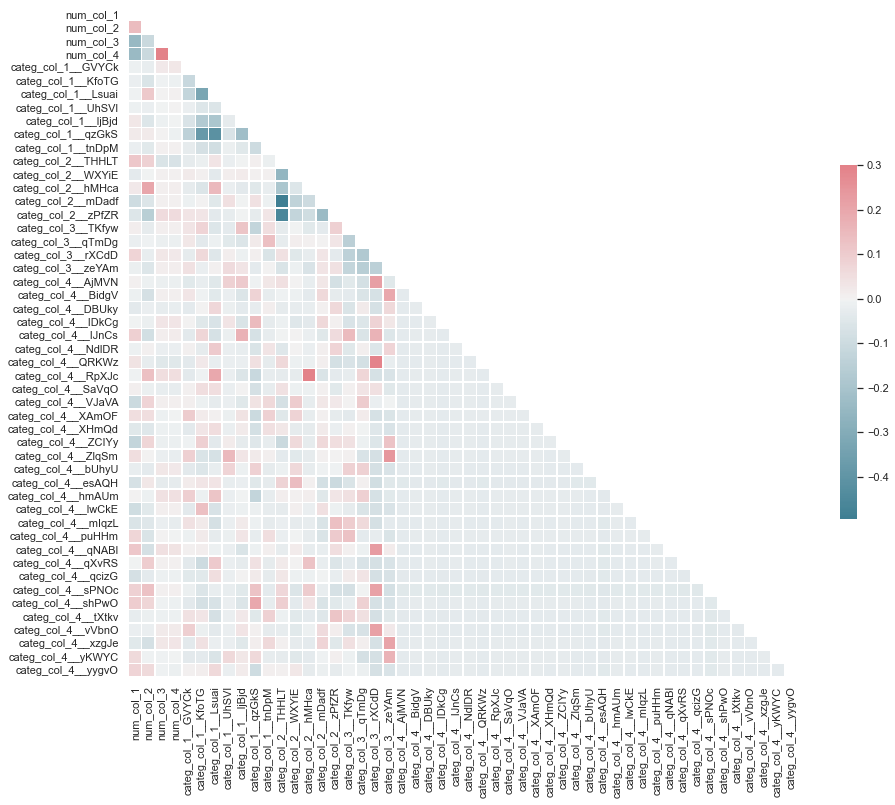

In [19]:
selected_columns = train.columns.tolist()
selected_columns.remove('poor')
plot_correlation_heatmap(train[selected_columns])

In general, the maximum correlation between the features are close to 0.3, which is no so high. Then, we will not remove any feature.

 ### Selecting the Best-Performing Features <a class="anchor" id="select-best-feature"></a>
 
 We will use the logit coefficients to select the most relevant features, using the *feature_selection.RFECV* class, which performs recursive feature elimination with cross-validation. The RFECV class starts by training a model using all of your features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.
 

In [20]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
   # df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop('poor',axis=1)
    all_y = df['poor']
    
    lr = LogisticRegression()
    selector = RFECV(lr,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)
print("Number of new features", len(cols))

Best Columns 
------------
['num_col_1', 'num_col_2', 'num_col_3', 'num_col_4', 'categ_col_1__GVYCk', 'categ_col_1__KfoTG', 'categ_col_1__Lsuai', 'categ_col_1__UhSVl', 'categ_col_1__ljBjd', 'categ_col_1__qzGkS', 'categ_col_2__THHLT', 'categ_col_2__WXYiE', 'categ_col_2__hMHca', 'categ_col_2__mDadf', 'categ_col_2__zPfZR', 'categ_col_3__TKfyw', 'categ_col_3__qTmDg', 'categ_col_3__rXCdD', 'categ_col_3__zeYAm', 'categ_col_4__AjMVN', 'categ_col_4__BidgV', 'categ_col_4__DBUky', 'categ_col_4__IDkCg', 'categ_col_4__IJnCs', 'categ_col_4__NdlDR', 'categ_col_4__QRKWz', 'categ_col_4__RpXJc', 'categ_col_4__SaVqO', 'categ_col_4__VJaVA', 'categ_col_4__XAmOF', 'categ_col_4__XHmQd', 'categ_col_4__ZCIYy', 'categ_col_4__ZlqSm', 'categ_col_4__bUhyU', 'categ_col_4__esAQH', 'categ_col_4__hmAUm', 'categ_col_4__lwCkE', 'categ_col_4__mIqzL', 'categ_col_4__puHHm', 'categ_col_4__qNABl', 'categ_col_4__qXvRS', 'categ_col_4__qcizG', 'categ_col_4__sPNOc', 'categ_col_4__shPwO', 'categ_col_4__tXtkv', 'categ_col_4__vVbn

As we can see, the selection method only remove one feature. Then, we will use the optimized columns to train the classification machine learning algorithms.

## Model Selection and Tuning <a class="anchor" id="model-selection"></a>

In this section, we will select the algorithm which gives the best predictions for our data. We're going to work with four algorithms: logistic regression, k-nearest neighbors, random forests and XGBoost, an implementation of gradient boosted decision trees. Most of the algorithms selected makes predictions using different methods. Moreover, XGBoost was one of the algorithm used to create ensembles in the winning solutions in the [Predicting Poverty Competition](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/). In the following a briefly description of each of the algorithms used:

- The logistic regression algorithm works by calculating linear relationships between the features and the target variable and using those to make predictions.

- The k-nearest neighbors algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

- Random Forest are a large number of trees, combined (using averages or "majority rules") at the end of the process.

- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning. Gradient boosting machines also combine decision trees, but start the combining process at the beginning, instead of at the end as the random forest do. The XGBoost model for classification is called XGBClassifier.

We train a number of models across a 'grid' of values and then searched for the model that gave us the highest accuracy. We use model_selection.GridSearchCV() from Scikit-learn. The 'CV' in the name indicates that we're performing both grid search and cross validation at the same time.

In [21]:
# select the best classification model
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["poor"]
    
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "XGBClassifier",
            "estimator": XGBClassifier(),
            "hyperparameters":
                {
                    'max_depth': range (2, 10, 1), #2, 10, 1
                    'n_estimators': range(60, 220, 40),#(60, 220, 40)
                    'learning_rate': [0.1, 0.01, 0.05], #[0.1, 0.01, 0.05
                    'objective': ['binary:logistic'],
                    'eval_metric': ["logloss"],
                    'seed': [42],
                    'use_label_encoder':[False]

                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models


In [22]:
result_models = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.7589671261930012
Best Parameters: {'solver': 'liblinear'}

XGBClassifier
-------------
Best Score: 0.7610571125587032
Best Parameters: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 180, 'objective': 'binary:logistic', 'seed': 42, 'use_label_encoder': False}

KNeighborsClassifier
--------------------
Best Score: 0.7065753673685806
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.7457382214815937
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}



## Making predictions on holdout data <a class="anchor" id="prediction-houldout"></a>

Let's train it on the holdout data and create a file to save the predictions results.

In [30]:
# predict the holdout data and create a file with predictions results
def save_prediction_result_file(model,cols,filename="holdout_predictions.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    accuracy = accuracy_score(holdout["poor"], predictions)
    
    print("Accuracy of the holdout data is:", accuracy)
    holdout_ids = holdout_data.index
    prediction_results_df = {"id": holdout_ids,
                 "poor": predictions}
    prediction_results = pd.DataFrame(prediction_results_df)

    prediction_results.to_csv(filename,index=False)

# sort the results_model list to select the model with the highest score
result_models_sorted = sorted(result_models, key=lambda k: k['best_score'], reverse=True)
best_rf_model = result_models_sorted[0]["best_model"]
print("Best Model: {}".format(result_models_sorted[0]["name"]))
save_prediction_result_file(best_rf_model,cols)

Best Model: XGBClassifier
Accuracy of the holdout data is: 0.7505154639175258


## Project Workflow  <a class="anchor" id="project-workflow"></a>
The complete project workflow is presented in the following cell, just in case the user prefers to go straight to run all the process.

In [33]:
train = load_dataset("Exercise_train.csv")
holdout = load_dataset("Exercise_test.csv")
train = pre_process(train)
holdout = pre_process(holdout)
cols = select_features(train)
result_models = select_model(train,cols)
result_models_sorted = sorted(result_models, key=lambda k: k['best_score'], reverse=True)
print("Best Model: {}".format(result_models_sorted[0]["name"]))
save_prediction_result_file(best_rf_model,cols)

Best Columns 
------------
['num_col_1', 'num_col_2', 'num_col_3', 'num_col_4', 'categ_col_1__GVYCk', 'categ_col_1__KfoTG', 'categ_col_1__Lsuai', 'categ_col_1__UhSVl', 'categ_col_1__ljBjd', 'categ_col_1__qzGkS', 'categ_col_2__THHLT', 'categ_col_2__WXYiE', 'categ_col_2__hMHca', 'categ_col_2__mDadf', 'categ_col_2__zPfZR', 'categ_col_3__TKfyw', 'categ_col_3__qTmDg', 'categ_col_3__rXCdD', 'categ_col_3__zeYAm', 'categ_col_4__AjMVN', 'categ_col_4__BidgV', 'categ_col_4__DBUky', 'categ_col_4__IDkCg', 'categ_col_4__IJnCs', 'categ_col_4__NdlDR', 'categ_col_4__QRKWz', 'categ_col_4__RpXJc', 'categ_col_4__SaVqO', 'categ_col_4__VJaVA', 'categ_col_4__XAmOF', 'categ_col_4__XHmQd', 'categ_col_4__ZCIYy', 'categ_col_4__ZlqSm', 'categ_col_4__bUhyU', 'categ_col_4__esAQH', 'categ_col_4__hmAUm', 'categ_col_4__lwCkE', 'categ_col_4__mIqzL', 'categ_col_4__puHHm', 'categ_col_4__qNABl', 'categ_col_4__qXvRS', 'categ_col_4__qcizG', 'categ_col_4__sPNOc', 'categ_col_4__shPwO', 'categ_col_4__tXtkv', 'categ_col_4__vVbn

## Conclusion <a class="anchor" id="conclusion"></a>

In this project, we analyzed household survey data to predict if a household is poor or not. The conclusion we reached are the followings:
- The features are not too correlated with a maximum correlation close to 0.3.
- The feature selection method used (GridSearchCV with Logistic Regresion used as the model) only remove one feature. In future experiments should be consider other model as RandomForest with a different feature selection method as  RandomizedSearchCV instead of GridSearchCV.
- XGBoost achives the best score to predict poverty considering the algorithms compared.

### Future works

Future tasks that could be done to improve the results and analyze better the data could be:
- Continue to explore the data and create new features, following the workflow and using the functions we created. A further exploration could be done with the data obtained after the preprocess step in order to analyze the relation of the train feaures with the poor column.
- Use other strategies to handel missing values and treat outliers.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up the select_features() function.
- Use some different algorithms in the select_model() function, like LightGBM, CatBoost and Neural Networks with Keras, which were some of the algorithms that won the poverty prediction competition.
- Use other measures (recall, precision, f1, cross entropy, ROC AUC) to evaluate the performance of the algorithms.
